In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pygwalker as pyg
import seaborn as sns
from ydata_profiling import ProfileReport

from fwi_predict.constants import WQ_RANGES
from fwi_predict.wq import get_in_required_range

In [3]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [4]:
ds = pd.read_csv("../data/predict_dfs/train/measurements_with_metadata_predict_df.csv",
                 parse_dates=['sample_dt'])

In [5]:
report = ProfileReport(ds, title="Training data")

In [6]:
# This takes a while to run, get comfortable...
# report.to_file("../output/measurements_with_metadata_profile_report.html")

In [7]:
# pyg.walk(ds)

In [8]:
weather_vars = ['downward_shortwave_radiation_flux', 'precipitable_water_entire_atmosphere',
                'relative_humidity_2m_above_ground', 'specific_humidity_2m_above_ground',
                'temperature_2m_above_ground', 'total_cloud_cover_entire_atmosphere',
                'total_precipitation_surface', 'u_component_of_wind_10m_above_ground',
                'v_component_of_wind_10m_above_ground']

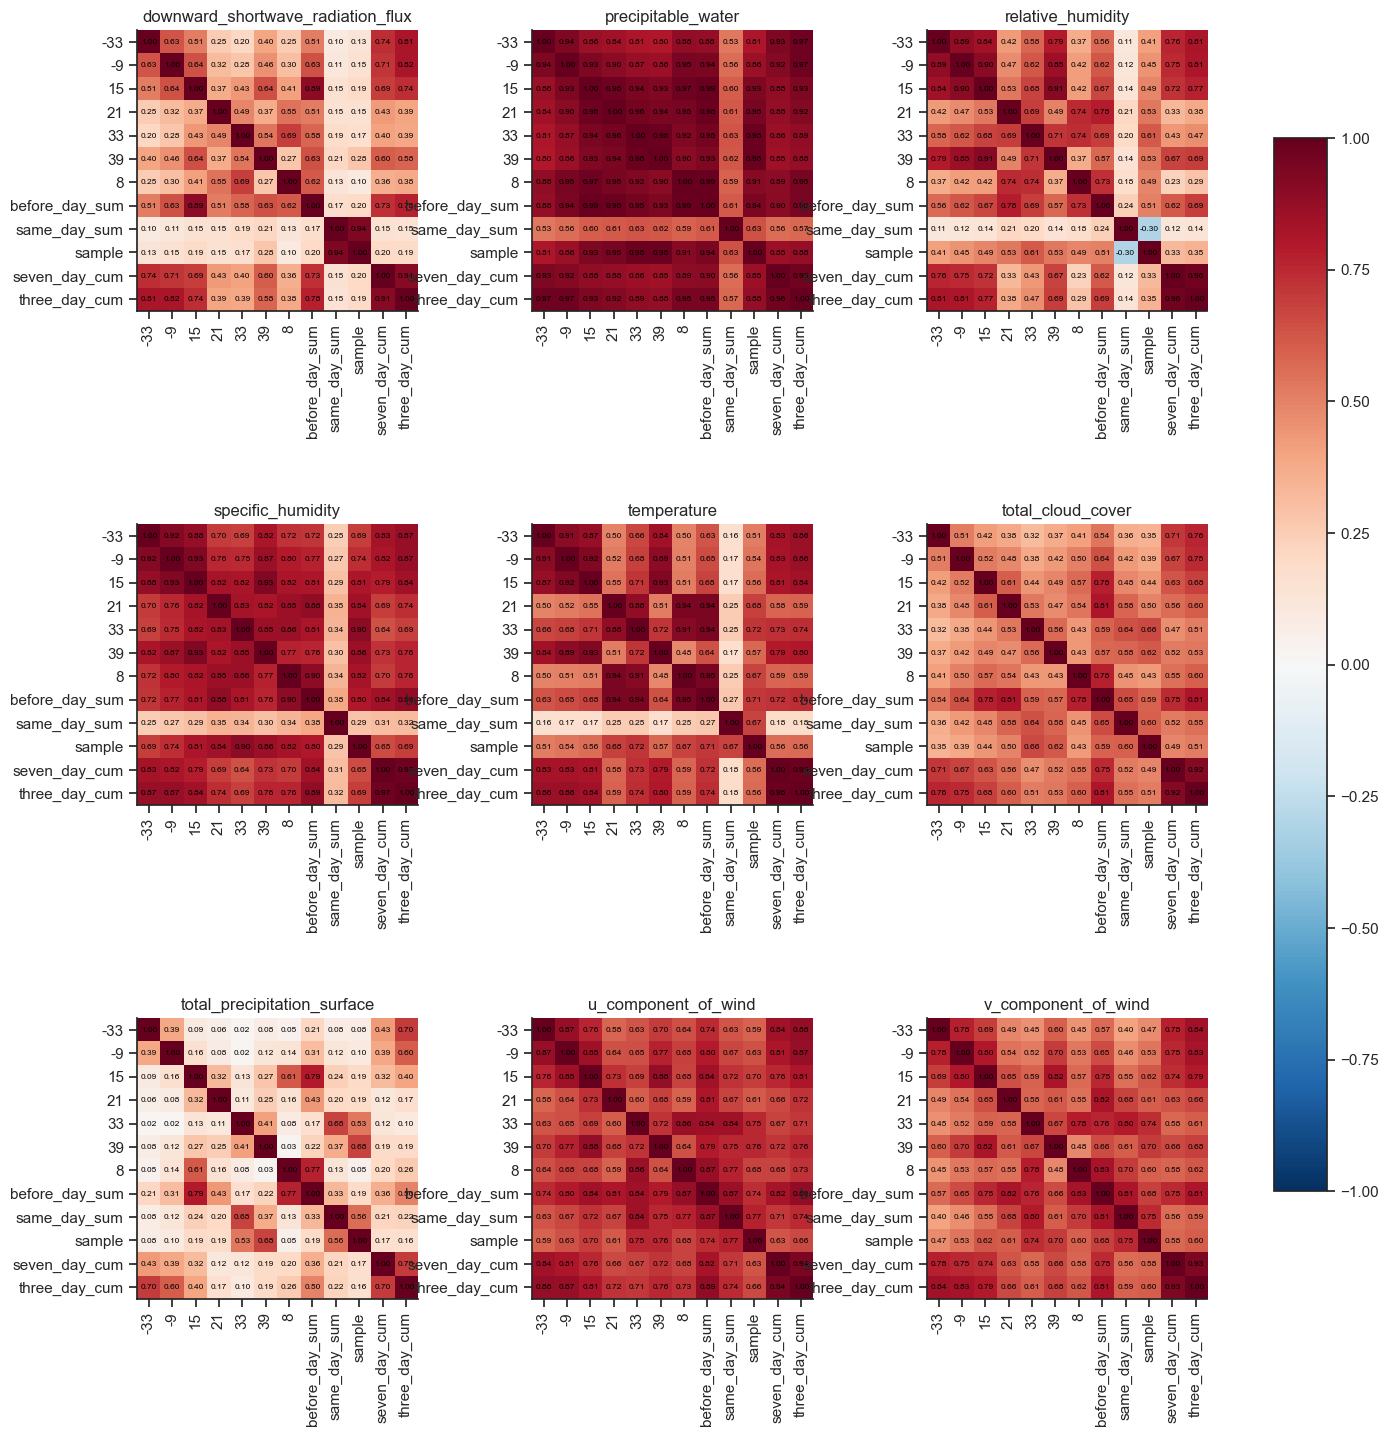

In [9]:
def plot_weather_var_correlations(df, weather_vars):
  """
  Creates and displays heatmaps showing correlations between different time variants
  of weather variables in a grid layout.
  
  Args:
      df (pd.DataFrame): DataFrame containing the weather variables
      weather_vars (list): List of weather variable prefixes to analyze
  """
  # Create subplot grid
  n_vars = len(weather_vars)
  n_cols = 3
  n_rows = (n_vars + n_cols - 1) // n_cols
  
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
  axes = axes.flatten()
  
  # Common suffixes we expect
  suffixes = ['_-60', '_-36', '_-12', '_-3', '_0', '_3', '_9', '_15', '_36',
              '_sample', '_three_day_cum', '_seven_day_cum']
  
  for idx, weather_var in enumerate(weather_vars):
    # Get relevant columns and sort by suffix
    relevant_cols = [col for col in df.columns if col.startswith(weather_var)]
    if not relevant_cols:
      print(f"No columns found with prefix {weather_var}")
      continue
    
    # Calculate correlation matrix
    corr_matrix = df[relevant_cols].corr()
    
    # Create heatmap
    im = axes[idx].imshow(corr_matrix, cmap='RdBu_r', aspect='equal', vmin=-1, vmax=1)
    
    # Clean up labels by removing prefix
    clean_labels = [col.replace(weather_var + '_', '') for col in relevant_cols]
    
    # Add labels
    axes[idx].set_xticks(range(len(clean_labels)))
    axes[idx].set_yticks(range(len(clean_labels)))
    axes[idx].set_xticklabels(clean_labels, rotation=90)
    axes[idx].set_yticklabels(clean_labels)
    
    # Add correlation values in each cell
    for i in range(len(relevant_cols)):
      for j in range(len(relevant_cols)):
        text = axes[idx].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                            ha='center', va='center', color='black',
                            fontsize=6)
    
    # Add title (shortened version)
    short_title = weather_var \
      .replace('_2m_above_ground', '') \
      .replace('_entire_atmosphere', '') \
      .replace('_10m_above_ground', '')
    axes[idx].set_title(short_title)
    
  # Remove empty subplots
  for idx in range(len(weather_vars), len(axes)):
    fig.delaxes(axes[idx])
    
  # Adjust layout
  plt.tight_layout()
  fig.colorbar(im, ax=axes, shrink=0.8, location='right')
  plt.show()

# Create correlation heatmaps for all weather variables
plot_weather_var_correlations(ds, weather_vars)


Observations
- Sample time radition flux is oddly less correlated with other radiation flux features. This could point to an error, but the correlations for other features make sense. Worth looking into this a bit more. Maybe it has something to do with the sample times being variable? 
- 

#### Check if correlations different in morning/evening

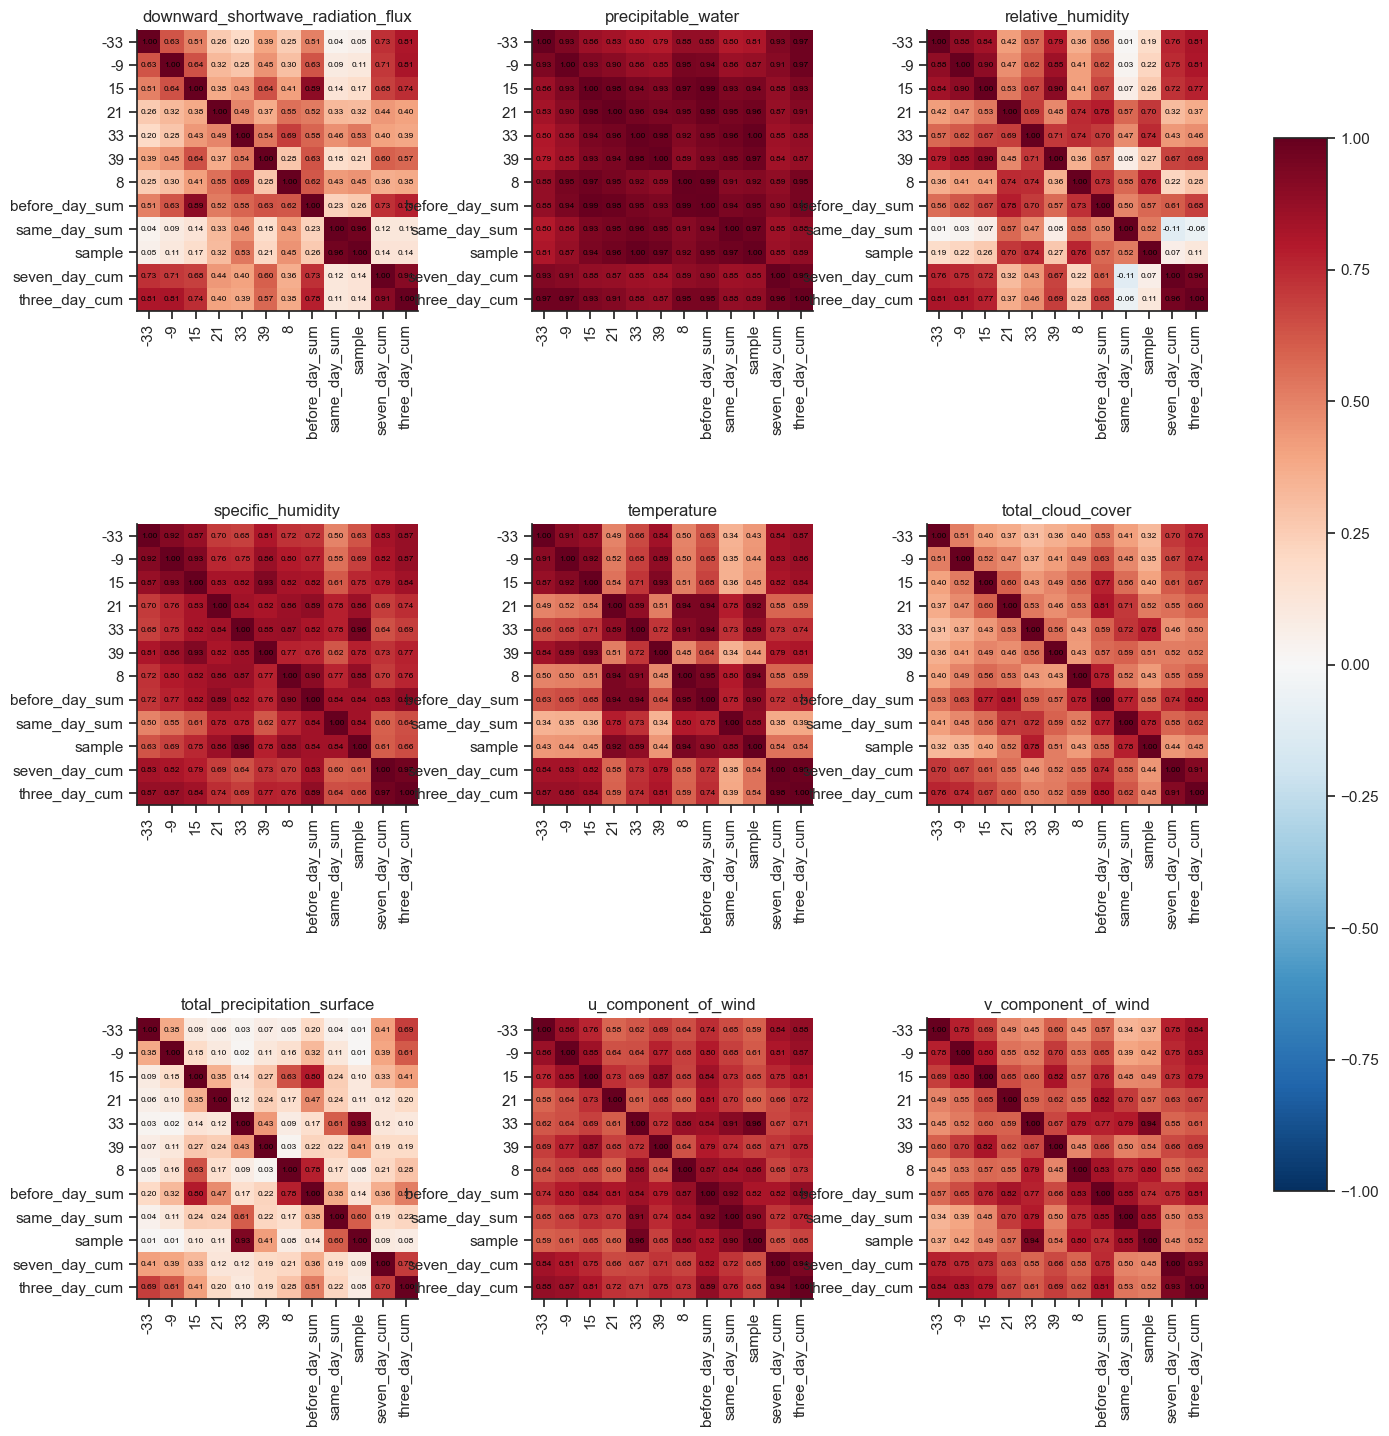

In [10]:
plot_weather_var_correlations(ds[ds['sample_dt'].dt.hour < 12], weather_vars)

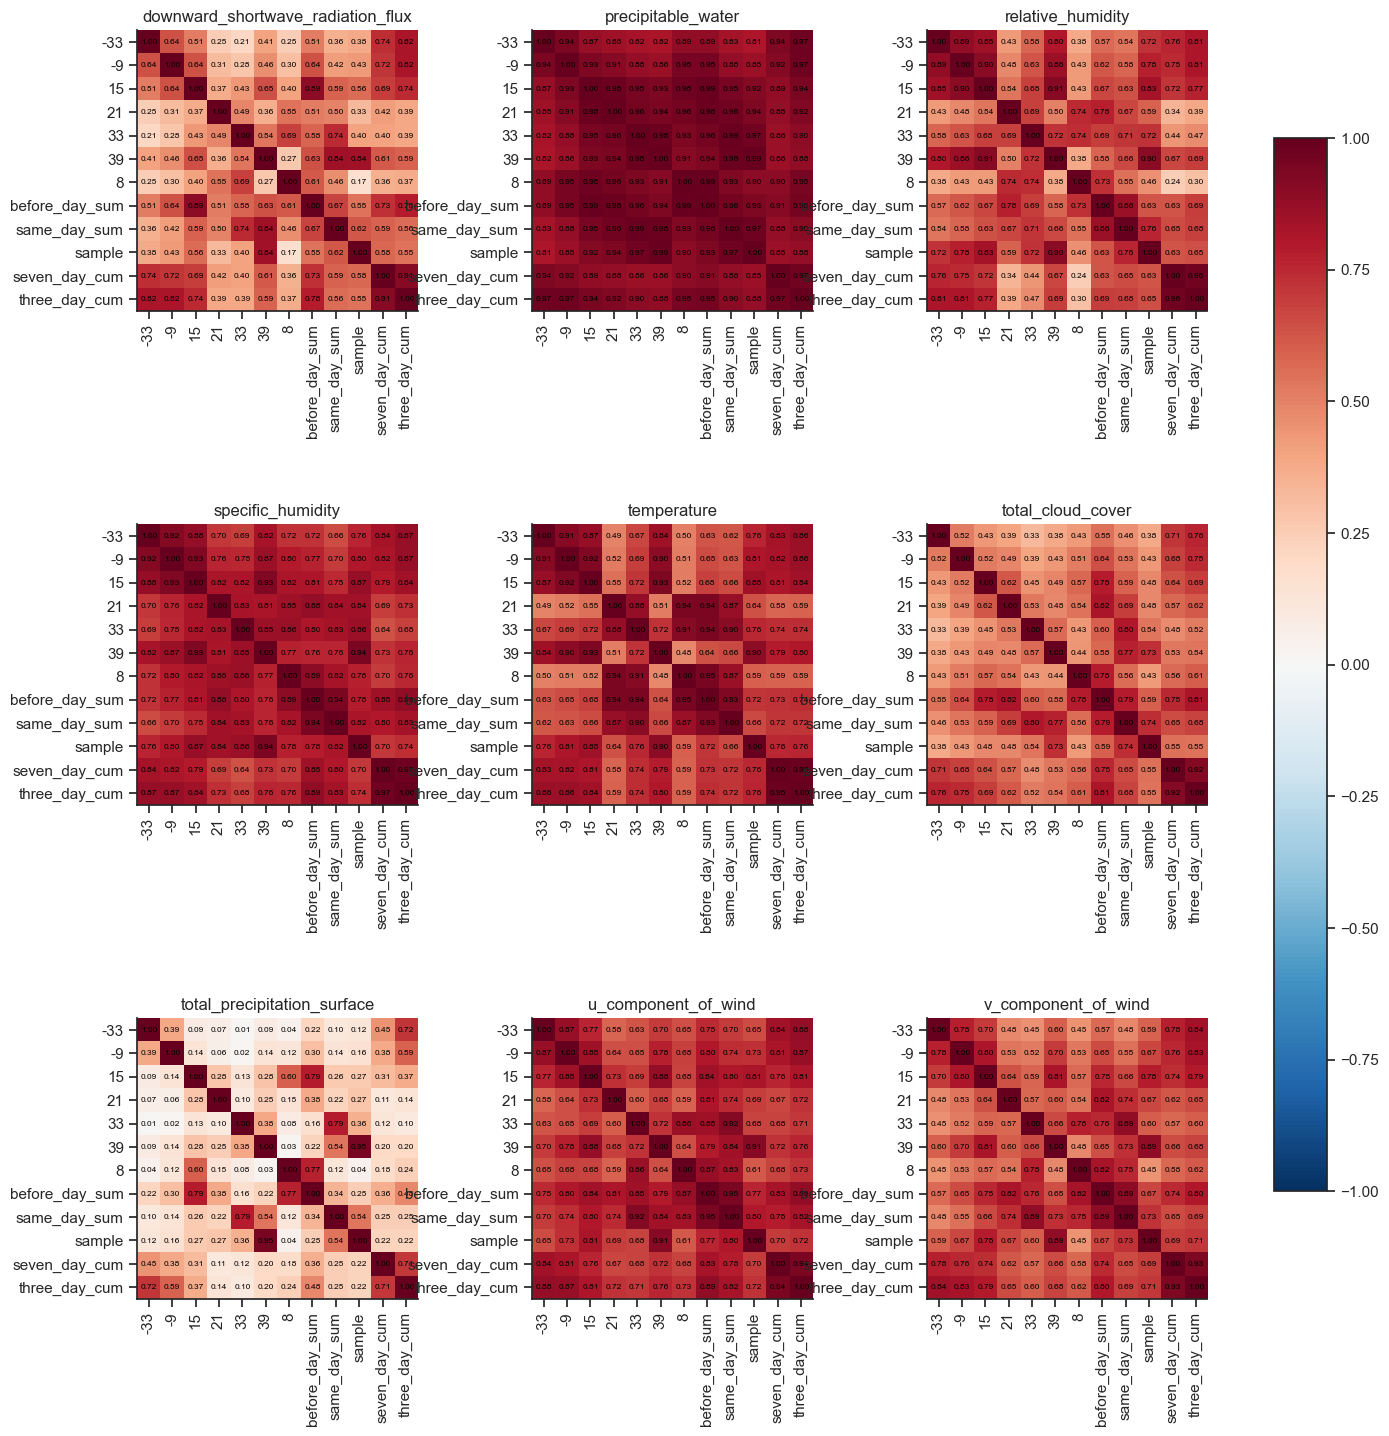

In [11]:
plot_weather_var_correlations(ds[ds['sample_dt'].dt.hour > 12], weather_vars)


In [12]:
# Get parameters for classification problem
ds['morning'] = ds['sample_dt'].dt.hour < 12
ds['time_of_day'] = ds['morning'].apply(lambda x: 'morning' if x else 'evening')
for param in WQ_RANGES.keys():
  range_name = param.split('_')[0] + '_in_range'
  ds[range_name] = get_in_required_range(param, ds[param], ds['time_of_day'])

ds = ds.drop(columns=['time_of_day'])

C:\Users\squaade\AppData\Local\Temp\ipykernel_37868\3076244722.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  ds['month_year'] = ds['sample_dt'].dt.to_period('M').astype(str)


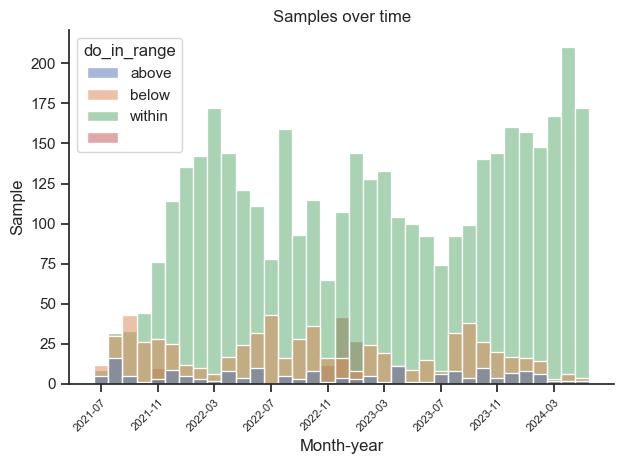

In [13]:
ds = ds.sort_values('sample_dt')
ds['month_year'] = ds['sample_dt'].dt.to_period('M').astype(str)
sns.histplot(ds, x='month_year', hue='do_in_range', alpha=.5, multiple='layer')
xtick_months = ds['month_year'].unique() # Get unique month-year values in the correct order
plt.xticks(
  ticks=range(0, len(xtick_months), 4),  # Every fourth month
  labels=xtick_months[::4],
  rotation=45,
  rotation_mode='anchor',
  fontsize=8,
  ha='right'
)
plt.title('Samples over time')
plt.xlabel('Month-year')
plt.ylabel('Sample')
plt.tight_layout()
plt.show()

Historically it appears we see more OOR examples from summer through fall. So it's weird our model is so wrong in these periods.
- More likely you've made an error in your code.
- Sad about those NAs

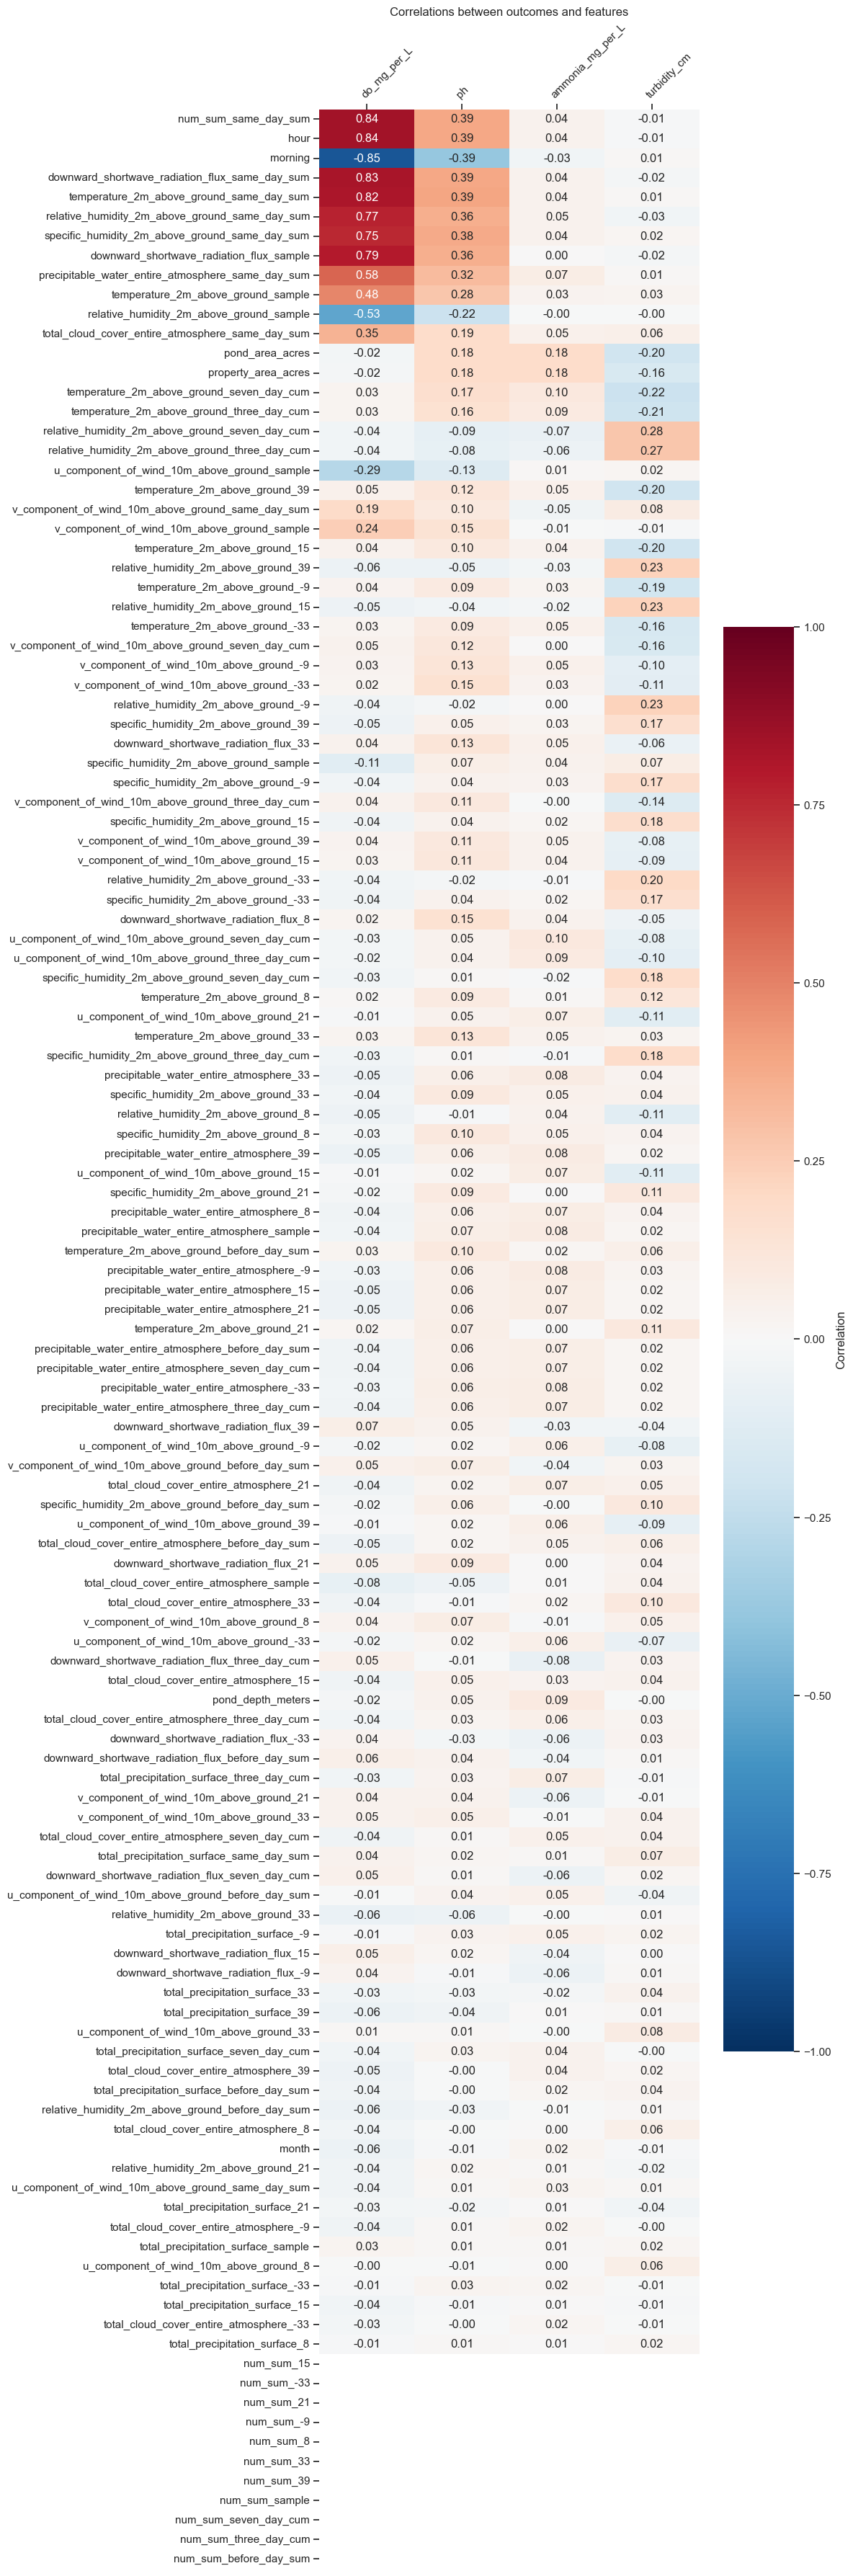

In [15]:
# Get outcome columns and feature columns
outcome_cols = ['do_mg_per_L', 'ph', 'ammonia_mg_per_L', 'turbidity_cm']
feature_cols = [col for col in ds.columns if col not in outcome_cols + ['sample_dt', 'pond_id', 'geometry', 'sample_idx', 'month_year', 'region', 'farm_id', 'do_in_range',
                                                                        'ph_in_range', 'ammonia_in_range', 'turbidity_in_range']]

# Calculate correlations between outcomes and features
correlations = ds[outcome_cols + feature_cols].corr().loc[feature_cols, outcome_cols]
correlations = correlations.loc[correlations.apply(lambda x: x.abs().sum(), axis=1).sort_values(ascending=False).index]

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 36))
sns.heatmap(correlations, 
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Correlation'},
            ax=ax)

ax.xaxis.tick_top() # Rotate them 45 degrees
ax.xaxis.set_label_position('top')
ax.set_title('Correlations between outcomes and features')
plt.xticks(rotation=45, rotation_mode='anchor', ha='left')
plt.tight_layout()
plt.show()

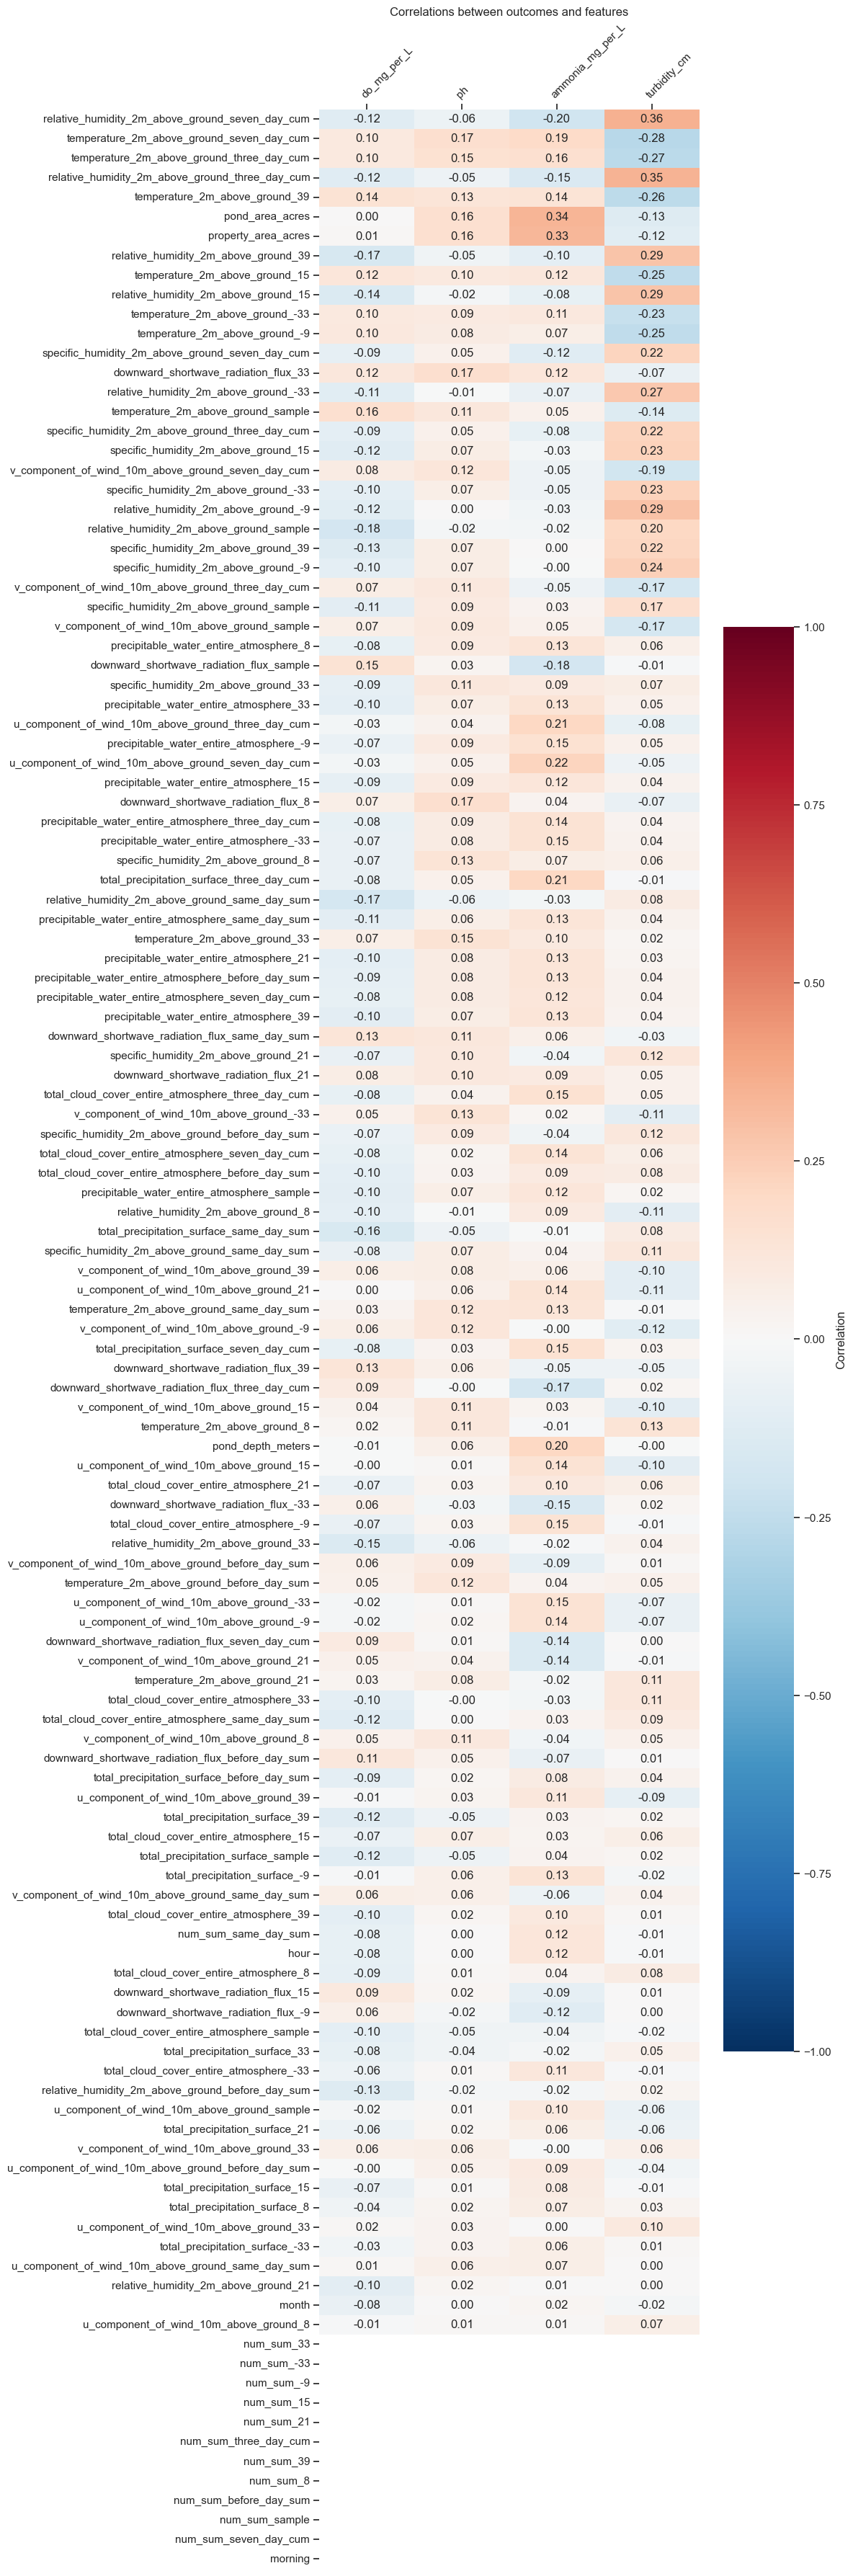

In [18]:
# Calculate correlations between outcomes and features
correlations = ds.loc[~ds['morning'], outcome_cols + feature_cols].corr().loc[feature_cols, outcome_cols]
correlations = correlations.loc[correlations.apply(lambda x: x.abs().sum(), axis=1).sort_values(ascending=False).index]

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 36))
sns.heatmap(correlations, 
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Correlation'},
            ax=ax)

ax.xaxis.tick_top() # Rotate them 45 degrees
ax.xaxis.set_label_position('top')
ax.set_title('Correlations between outcomes and features')
plt.xticks(rotation=45, rotation_mode='anchor', ha='left')
plt.tight_layout()
plt.show()